# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


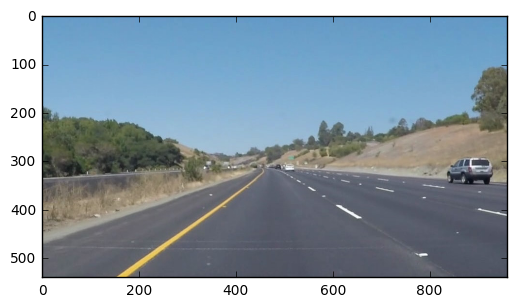

In [2]:
#reading in an image
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

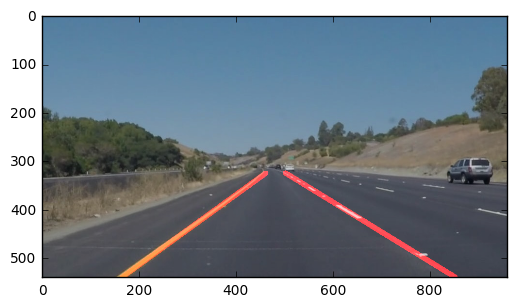

In [12]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#transform to grayscale
gray=grayscale(image)

#perform gaussian blur
kernel_size=5
gray_gauss=gaussian_blur(gray, kernel_size)
plt.imshow(gray_gauss,'gray')


#perform canny edge detection
low_thresh=120
high_thresh=150
edges=canny(gray_gauss, low_thresh, high_thresh)
plt.imshow(edges,'gray')

#define region of interest
imshape = image.shape
pic_top=325
pic_bot=imshape[0]
vertices = np.array([[(110,pic_bot),(450, pic_top), (510, pic_top), (900,pic_bot)]], dtype=np.int32)
edges_cut=region_of_interest(edges, vertices)
plt.imshow(edges_cut,'gray')

#perform Hough Transform
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 10     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 5 #minimum number of pixels making up a line
max_line_gap = 10   # maximum gap in pixels between connectable line segments
lines=hough_lines(edges_cut, rho, theta, threshold, min_line_len, max_line_gap) #gives the image of the hough_lines
plt.imshow(lines)

layover=weighted_img(lines, image, α=0.8, β=1., λ=0.)
plt.imshow(layover)

#perform extrapolation
extrap_lines = cv2.HoughLinesP(edges_cut, rho, theta, threshold, np.array([]),
                            min_line_len, max_line_gap) #this gives the arry of x1,y1,x2,y2 of each line created

#calculate the slope and split this into two different lines (left is pos slope, right is neg slope)
left=[]  #initialize left lane line set
right=[] #initialize right lane line set
ml=[]    #initialize left slope set
mr=[]    #initialize right slope set
yintl=[] #y intercept values for left set
yintr=[] #y intercept values for right set

for line in extrap_lines:
    for x1,y1,x2,y2 in line:
        m=(y2-y1)/(x2-x1)
        #print(m)
        if (m > -0.8) and (m < -0.5): #left line
                left.append(line)
                ml.append(m)
                yintl.append(y1-m*x1)
        elif (m > 0.5) and (m <0.8): #right line
                right.append(line)
                mr.append(m)
                yintr.append(y1-m*x1)
#print(ml)
#print(mr)
mave_left=np.mean(ml)
mave_right=np.mean(mr)
yint_avel=np.mean(yintl)
yint_aver=np.mean(yintr)

#perform a linear regression to get y=mx+b equations
xvl=[]   #initialize x and y value vectors for left and right sets
xvr=[]
yvl=[]
yvr=[]
for line in left:
    for x1,y1,x2,y2 in line:
        xvl.append(x1)
        xvl.append(x2)
        yvl.append(y1)
        yvl.append(y2)
xavel=np.mean(xvl)
yavel=np.mean(yvl)
sum1=0
sum2=0
for i in range(len(xvl)):
    sum1=sum1+((xvl[i]-xavel)*(yvl[i]-yavel))
    sum2=sum2+((xvl[i]-xavel)**2)
beta_l=sum1/sum2
alpha_l=yavel-beta_l*xavel

#left line endpoints:
y1_left=int(pic_top)
x1_left=int((y1_left-alpha_l)/beta_l)
y2_left=int(pic_bot)
x2_left=int((y2_left-alpha_l)/beta_l)

for line in right:
    for x1,y1,x2,y2 in line:
        xvr.append(x1)
        xvr.append(x2)
        yvr.append(y1)
        yvr.append(y2)
xaver=np.mean(xvr)
yaver=np.mean(yvr)
sum3=0
sum4=0
for i in range(len(xvr)):
    sum3=sum3+((xvr[i]-xaver)*(yvr[i]-yaver))
    sum4=sum4+((xvr[i]-xaver)**2)
beta_r=sum3/sum4
alpha_r=yaver-beta_r*xaver
#right line endpoints:
y1_right=int(pic_top)
x1_right=int((y1_right-alpha_r)/beta_r)
y2_right=int(pic_bot)
x2_right=int((y2_right-alpha_r)/beta_r)

#print(x1_left)
#draw the lines on the image
line_image = np.copy(image)*0 # creating a blank to draw lines on
cv2.line(line_image, (x1_left, y1_left), (x2_left, y2_left), (255, 0, 0), 10)
cv2.line(line_image, (x1_right, y1_right), (x2_right, y2_right), (255, 0, 0), 10)

plt.imshow(line_image)
drawn=weighted_img(line_image, image, α=0.8, β=1., λ=0.)
plt.imshow(drawn)
#draw_lines(line_image, lines, color=[255, 0, 0], thickness=2)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    #transform to grayscale
    gray=grayscale(image)

    #perform gaussian blur
    kernel_size=5
    gray_gauss=gaussian_blur(gray, kernel_size)
    #plt.imshow(gray_gauss,'gray')


    #perform canny edge detection
    low_thresh=120
    high_thresh=150
    edges=canny(gray_gauss, low_thresh, high_thresh)
    #plt.imshow(edges,'gray')

    #define region of interest
    imshape = image.shape
    pic_top=325
    pic_bot=imshape[0]
    vertices = np.array([[(110,pic_bot),(450, pic_top), (510, pic_top), (900,pic_bot)]], dtype=np.int32)
    edges_cut=region_of_interest(edges, vertices)
    #plt.imshow(edges_cut,'gray')

    #perform Hough Transform
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 6 #minimum number of pixels making up a line
    max_line_gap = 10   # maximum gap in pixels between connectable line segments
    lines=hough_lines(edges_cut, rho, theta, threshold, min_line_len, max_line_gap) #gives the image of the hough_lines
    #plt.imshow(lines)

    #layover=weighted_img(lines, image, α=0.8, β=1., λ=0.)
    #plt.imshow(layover)

    #perform extrapolation
    extrap_lines = cv2.HoughLinesP(edges_cut, rho, theta, threshold, np.array([]),
                                min_line_len, max_line_gap) #this gives the arry of x1,y1,x2,y2 of each line created

    #calculate the slope and split this into two different lines (left is pos slope, right is neg slope)
    left=[]  #initialize left lane line set
    right=[] #initialize right lane line set
    ml=[]    #initialize left slope set
    mr=[]    #initialize right slope set
    yintl=[] #y intercept values for left set
    yintr=[] #y intercept values for right set

    for line in extrap_lines:
        for x1,y1,x2,y2 in line:
            m=(y2-y1)/(x2-x1)
            #print(m)
            if (m > -0.85) and (m < -0.5): #left line
                    left.append(line)
                    ml.append(m)
                    yintl.append(y1-m*x1)
            elif (m > 0.5) and (m <0.8): #right line
                    right.append(line)
                    mr.append(m)
                    yintr.append(y1-m*x1)
    #print(ml)
    #print(mr)
    mave_left=np.mean(ml)
    mave_right=np.mean(mr)
    yint_avel=np.mean(yintl)
    yint_aver=np.mean(yintr)

    #perform a linear regression to get y=mx+b equations
    xvl=[]   #initialize x and y value vectors for left and right sets
    xvr=[]
    yvl=[]
    yvr=[]
    for line in left:
        for x1,y1,x2,y2 in line:
            xvl.append(x1)
            xvl.append(x2)
            yvl.append(y1)
            yvl.append(y2)
    xavel=np.mean(xvl)
    yavel=np.mean(yvl)
    sum1=0
    sum2=0
    for i in range(len(xvl)):
        sum1=sum1+((xvl[i]-xavel)*(yvl[i]-yavel))
        sum2=sum2+((xvl[i]-xavel)**2)
        #print(sum2)
    beta_l=sum1/sum2
    alpha_l=yavel-beta_l*xavel

    #left line endpoints:
    y1_left=int(pic_top)
    x1_left=int((y1_left-alpha_l)/beta_l)
    y2_left=int(pic_bot)
    x2_left=int((y2_left-alpha_l)/beta_l)

    for line in right:
        for x1,y1,x2,y2 in line:
            xvr.append(x1)
            xvr.append(x2)
            yvr.append(y1)
            yvr.append(y2)
    xaver=np.mean(xvr)
    yaver=np.mean(yvr)
    sum3=0
    sum4=0
    for i in range(len(xvr)):
        sum3=sum3+((xvr[i]-xaver)*(yvr[i]-yaver))
        sum4=sum4+((xvr[i]-xaver)**2)
    beta_r=sum3/sum4
    alpha_r=yaver-beta_r*xaver
    #right line endpoints:
    y1_right=int(pic_top)
    x1_right=int((y1_right-alpha_r)/beta_r)
    y2_right=int(pic_bot)
    x2_right=int((y2_right-alpha_r)/beta_r)

    #print(x1_left)
    #draw the lines on the image
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    cv2.line(line_image, (x1_left, y1_left), (x2_left, y2_left), (255, 0, 0), 10)
    cv2.line(line_image, (x1_right, y1_right), (x2_right, y2_right), (255, 0, 0), 10)

    #plt.imshow(line_image)
    drawn=weighted_img(line_image, image, α=0.8, β=1., λ=0.)
    #plt.imshow(drawn)
    #draw_lines(line_image, lines, color=[255, 0, 0], thickness=2)
    
    return drawn

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:28<00:00,  7.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 32.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:32<00:00,  7.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 36s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!




My reflection:
This project was very interesting. I got to use canny line detection and hough transformation techniques to find lane lines, and then used linear regression to find a smooth line through the whole lane. Then I was able to run this with a video and see the results. For the extrapolation, first I separated the hough lines by positive and negative slope, leaving out any outliers. Then, for each the left and right, I split up the x and y coordinates and did a linear regression equation to find the slope of the line through the points, and the corresponding y-intercept.

One potential problem with this algorithm could be when there are sharp curves. For now, all the lines on the left have the same slope direction, and all on the right have the same slope direction. But with a sharp curve, it could be possible that some part of the line is in the opposite direction than the rest. Another problem could be weather and light conditions. If the lighting is too bright, or the weather is rainy, the lines may not be as distinguished. Another problem could be if the vehicle is not directly in the center of the lane, part of a lane line may be cut off.

Possible improvements could be to make the transition between slides more smooth. At some points it is a little choppy. Also, it can be made more robust by being able to detect curves as well, not just straight lines.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

ZeroDivisionError: division by zero

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))